# 00. Requirements

In [2]:
# 기본 라이브러리 import
import os

import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import itertools as it

from dateutil.relativedelta import relativedelta
from datetime import *
import calendar
from scipy import stats
import math

# 경고 무시
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set_style('white')
%matplotlib inline

# 정상성 검정 adf
from statsmodels.tsa.stattools import adfuller



# LabelEncoding
from sklearn.preprocessing import LabelEncoder

# 머신러닝
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from math import sqrt

# 시계열분석
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# 메타데이터 에측용(Prophet)
from fbprophet import Prophet

# 평가지표
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


# 01. Data Load

In [3]:
os.getcwd()

'C:\\Users\\200824\\PycharmProjects\\Study\\BigContest'

In [88]:
train = pd.read_excel('../Python_Dataset/2021_BigContest_수산Biz/2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_문제데이터.xlsx')
check = pd.read_excel('../Python_Dataset/2021_BigContest_수산Biz/자율평가데이터.xlsx')

# 02. Preparing Data

In [5]:
# META-DATA 예측용 Data Preparation
def prepare_df_meta(df, subject):
    # 품목별 저장
    df = train.loc[train['P_NAME'] == subject]
    
    #불필요 column 제거
    df.drop(['P_TYPE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME'], axis=1, inplace=True)
    
    # Label Encoding
    encoder = LabelEncoder()

    cat_features = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_IMPORT_TYPE'] 

    for i in cat_features:
        df[i] = encoder.fit_transform(df[i])
        
    meta_df = df
        
    return meta_df

In [6]:
# 회귀분석 모델용 Data Preparation
def prepare_df_modeling(df, subject):
    # 품목별 저장
    df = train.loc[train['P_NAME'] == subject]
    
    #불필요 column 제거
    df.drop(['P_TYPE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME'], axis=1, inplace=True)
    
    # index 설정
    df  = df.set_index('REG_DATE')
    
    # Label Encoding
    encoder = LabelEncoder()

    cat_features = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_IMPORT_TYPE'] 

    for i in cat_features:
        df[i] = encoder.fit_transform(df[i])
        
    model_df = df
        
    return model_df

In [7]:
# 시계열분석 모델용 Data Preparation
def prepare_df_arima(df, subject):
    # 품목별 저장
    df = train.loc[train['P_NAME'] == subject]
    arima_df = df.groupby('REG_DATE').mean()
    
    return arima_df

# 03. Predicting Meta-Data

In [8]:
# Predicting META-DATA
def meta_predict(df, subject, year):
    
    # Preparation
    df = prepare_df_meta(df, subject)
    
    # 주어진 데이터셋의 META-DATA 대상
    meta_col  = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_IMPORT_TYPE']   
    
    weekly_predict= []
    weekly_predict = pd.DataFrame(weekly_predict)
    
    for col in meta_col:
        # y column 중복시 제거        
        j = df.columns.isin(['y'])
        dropYN = np.any(j==True)
        
        if dropYN == True:
            df.drop(['y'], axis=1, inplace=True)
        
        # ds column 중복시 제거
        k = df.columns.isin(['ds'])
        renameYN = np.any(k==True)
        if renameYN ==  True:
            df.rename(columns = {col : 'y'}, inplace=True)
        else:
            df.rename(columns = {'REG_DATE' : 'ds', col : 'y'}, inplace=True)
            
        df_prophet = Prophet(changepoint_prior_scale = 0.15, daily_seasonality = True)
        df_prophet.fit(df)

        global df_forecast
        fcast_time = 78 # 2020.01 ~ 2021.06까지 추출
        df_forecast = df_prophet.make_future_dataframe(periods = fcast_time, freq = 'W-MON')
        df_forecast = df_prophet.predict(df_forecast)
                
        weekly_predict_dup = df_forecast.groupby('ds')['yhat'].agg(**{col : 'mean'}).reset_index()
        weekly_predict_dup[col] = weekly_predict_dup[col].astype(int)
        weekly_predict[col] = weekly_predict_dup[col]
    
    weekly_predict['ds'] = weekly_predict_dup['ds']
    weekly_predict = weekly_predict.loc[weekly_predict['ds'].dt.year == year]        
    weekly_predict = weekly_predict.set_index('ds')
    
    return weekly_predict

# 04. Modeling

## 04-1. Parameters

In [9]:
# 파라미터 지정

# lgb_params_grid = {
#     'num_leaves': [5,10,20,30],
#     'min_data_in_leaf': [10,50, 100, 500],
#     'lambda_l1': [0, 1, 1.5],
#     'lambda_l2': [0, 1]
# }

lgb_params_grid = {
    'num_leaves': [10,20,30,40],
    'min_data_in_leaf': [10,100, 500, 1000],
    'lambda_l1': [0, 1, 2.0],
    'lambda_l2': [0, 1]
}

svr_params_grid = { 
    'kernel':['rbf','poly'],
    'degree':[2,3,4,5,6,7],
    'epsilon':[0.1,0.2,1,10,20,30]
}

# svr_params_grid = { 
#     'kernel':['rbf','poly'],
#     'degree':[2,4,6,8,10,12],
#     'epsilon':[0.1,0.2,1,10,20,30]
# }

# rf_params_grid = {
#     'n_estimators': [10, 100, 1000],
#     'max_depth': [6,8,10,12],
#     'min_samples_leaf': [8,12,18],
#     'min_samples_split': [8,16,20]
# }

rf_params_grid = {
    'n_estimators': [10, 100, 1000],
    'max_depth': [8,10,12, 14],
    'min_samples_leaf': [8,12,18],
    'min_samples_split': [8,16,20]
}

## 04-2. 회귀모델 구축

In [10]:
# 회귀모델
def Regression_model(df, subject, year, model_type):

    # test set 만들기용
    test_df = meta_predict(df, subject, year)
    
    # train set 만들기용
    tr = prepare_df_modeling(df, subject)
    ## 나중에 여기서 혜린님이 추가해준 소비자물가지수 등의 excel(2015~2019)과 concat ## ==> df_all

    ## 2015 ~ 2019 데이터로 학습
    X = tr.drop(columns = ['P_PRICE'])
    y = tr['P_PRICE']

    ## train_test_split (validation set : 15%)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, shuffle = True, random_state = 2021)

    ## 인식불가 문자 제거
    X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
    X_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_val.columns]

    if(model_type=="lgbm"):        
        # LGBM 학습
        m = LGBMRegressor(boosting_type='gbdt', num_boost_round=2000, learning_rate=0.01)
        m_grid = GridSearchCV(estimator=m,param_grid=lgb_params_grid,n_jobs=10,verbose=3)
        m_grid.fit(X_train,y_train) 
        m = m_grid
        
    elif(model_type=="rf"):
        # RF 학습
        m = RandomForestRegressor(random_state=0, n_jobs=1)
        m_grid = GridSearchCV(m, param_grid = rf_params_grid, cv = 3, n_jobs = -1)
        m_grid.fit(X_train,y_train) 
        m = m_grid
        
    elif(model_type=="svr"):
        # SVR 학습
        m = SVR(kernel='rbf')
        m_grid = GridSearchCV(estimator=m, param_grid=svr_params_grid) 
        m_grid.fit(X_train, y_train)
        m = m_grid
        
    P1 = m.predict(X_val)        
    P1_rmse = mean_squared_error(y_val, P1)
    P1_rmse = P1_rmse**0.5

    print('Validation Check (train vs validation) {0} {1}의 {2}년 RMSE : {3}'.format(subject, model_type, year, P1_rmse))     
    print('\n\n========== Predicted ==========')

    final_predict = m.predict(test_df)

    final_predict = np.round(final_predict,2)
    final_predict = pd.DataFrame(final_predict)
    final_predict = final_predict.rename(columns={0 : 'P_PRICE'})
    test_df = test_df.reset_index()
    final_predict['REG_DATE'] = test_df['ds']
    final_predict = final_predict.set_index('REG_DATE')


    return final_predict

## 04-3. 시계열분석 모델 구축

In [11]:
# ARIMA 예측모델
def ARIMA_model_2020(df):
    import warnings
    
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    
    warnings.simplefilter('ignore', ConvergenceWarning) 
    # Ignore convergence warning
    
    p = [1, 2, 4, 6, 8]
    d = q = range(0, 2)
    params_arima = list(it.product(p,d,q))
    
    combs = {}
    aics = []
    
    for i, param in enumerate(params_arima):
        try:
            m = ARIMA(df, 
                      order=param,
                      enforce_invertibility=False,
                      enforce_stationarity=False)
            m_fit = m.fit()
            combs.update({m_fit.aic : param})
            aics.append(m_fit.aic)
            
        except: continue
        
    m_arima_best_aic_idx = min(aics)        
    m_arima = ARIMA(df,
                    order=combs[m_arima_best_aic_idx],
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    m_arima_fit = m_arima.fit()            
    
    return m_arima_fit.forecast(52)



def ARIMA_model_2021(df):
    import warnings
    
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    
    warnings.simplefilter('ignore', ConvergenceWarning) 
    # Ignore convergence warning
    
    p = [1, 2, 4, 6, 8]
    d = q = range(0, 2)
    params_arima = list(it.product(p,d,q))
    
    combs = {}
    aics = []
    
    for i, param in enumerate(params_arima):
        try:
            m = ARIMA(df, 
                      order=param,
                      enforce_invertibility=False,
                      enforce_stationarity=False)
            m_fit = m.fit()
            combs.update({m_fit.aic : param})
            aics.append(m_fit.aic)
            
        except: continue
        
    m_arima_best_aic_idx = min(aics)        
    m_arima = ARIMA(df,
                    order=combs[m_arima_best_aic_idx],
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    m_arima_fit = m_arima.fit()            
    
    return m_arima_fit.forecast(26)

In [12]:
# ARIMA 실행 모델
def ARIMA_Predict_2020(df):
    y_pred = ARIMA_model_2020(df)
    y_pred = pd.DataFrame(y_pred)
    y_pred['DateTime'] = pd.date_range('2020-01-06','2020-12-28	', freq='W-MON')
    y_pred = y_pred.rename(columns={'DateTime': 'DateTime','predicted_mean' : 'P_PRICE'})
    y_pred = y_pred[['DateTime','P_PRICE']]
    y_pred = round(y_pred, 2)
    y_pred.set_index('DateTime', inplace=True)
    print('\n\n========== A R I M A ==========')
    print('\n\n========== Predicted ==========')
    return y_pred

def ARIMA_Predict_2021(df):
    y_pred = ARIMA_model_2021(df)
    y_pred = pd.DataFrame(y_pred)
    y_pred['DateTime'] = pd.date_range('2021-01-04','2021-06-28', freq='W-MON')
    y_pred = y_pred.rename(columns={'DateTime': 'DateTime','predicted_mean' : 'P_PRICE'})
    y_pred = y_pred[['DateTime','P_PRICE']]
    y_pred = round(y_pred, 2)
    y_pred.set_index('DateTime', inplace=True)
    print('\n\n========== A R I M A ==========')
    print('\n\n========== Predicted ==========')
    return y_pred

## 04-4. Ensemble

In [13]:
def Ensemble_v(df, subject):
    # 가중치 모델
    
    global obj1_v
    global obj2_v
    global obj3_v
    global obj4_v
    
    t_df = prepare_df_arima(train,subject)
    
    ##############################################
    ######## 2020년 P_PRICE 예측값 구하기#########
    ##############################################
    obj1_v = Regression_model(df, subject, 2020, 'lgbm')
    obj2_v = Regression_model(df, subject, 2020, 'rf')
    obj3_v = Regression_model(df, subject, 2020, 'svr')  
    obj4_v = ARIMA_Predict_2020(t_df)
    
    ##############################################
    ######## 2021년 P_PRICE 예측값 구하기#########
    ##############################################
    pred1 = Regression_model(df, subject, 2021, 'lgbm')
    pred2 = Regression_model(df, subject, 2021, 'rf')
    pred3 = Regression_model(df, subject, 2021, 'svr')    
    pred4 = ARIMA_Predict_2021(t_df)
    
    # 2021년 row 수에 맞는 변수 선언
    global s_v
    s_v = pred1.shape[0]
    
    # List 생성
    global list_2021_v
    list_2021_v = []
    for i,v in enumerate(pred1.index):
        if str(v).split('-')[0] == '2021':
            list_2021_v.append(i)
    
    list_2021_v = pd.DataFrame(list_2021_v)
    
    # 예측값 List에 저장
    ## p1 (LGBM)
    pred1 = pred1.reset_index()
    list_2021_v['PRED_PRICE_LGBM'] = pred1['P_PRICE']
    
    ## p2 (RF)
    pred2 = pred2.reset_index()
    list_2021_v['PRED_PRICE_RF'] = pred2['P_PRICE']
    
    ## p3 (SVR)
    pred3 = pred3.reset_index()
    list_2021_v['PRED_PRICE_SVR'] = pred3['P_PRICE']
    
    ## p4 (ARIMA)
    pred4 = pred4.reset_index()
    list_2021_v['PRED_PRICE_ARIMA'] = pred4['P_PRICE']
    
    ## 2020년 기반 주차별로 제일 정확값 도출한 모델 선정
    vote_df = VoteModel(check, subject)
    list_2021_v['PREDICT_MODEL'] = vote_df['PREDICT_MODEL']
    
    # FINAL_PRICE 도출
    list_2021_v['FINAL_PRICE'] = '0'
    
    for i in range(list_2021_v.shape[0]):
        j= i+1
        if (list_2021_v[i:j][['PREDICT_MODEL']] == 'LGBM').bool():
            a = str(list_2021_v.iloc[i]['PRED_PRICE_LGBM'])
            list_2021_v[i:j]['FINAL_PRICE'] = list_2021_v[i:j]['FINAL_PRICE'].replace('0',a)
        elif (list_2021_v[i:j][['PREDICT_MODEL']] == 'RF').bool():
            a = str(list_2021_v.iloc[i]['PRED_PRICE_RF'])
            list_2021_v[i:j]['FINAL_PRICE'] = list_2021_v[i:j]['FINAL_PRICE'].replace('0',a)
        elif (list_2021_v[i:j]['PREDICT_MODEL'] == 'SVR').bool():
            a = str(list_2021_v.iloc[i]['PRED_PRICE_SVR'])
            list_2021_v[i:j]['FINAL_PRICE'] = list_2021_v[i:j]['FINAL_PRICE'].replace('0',a)
        elif (list_2021_v[i:j]['PREDICT_MODEL'] == 'ARIMA').bool():
            a = str(list_2021_v.iloc[i]['PRED_PRICE_ARIMA'])
            list_2021_v[i:j]['FINAL_PRICE'] = list_2021_v[i:j]['FINAL_PRICE'].replace('0',a)
    
    # 모델 결과값들의 평균 P_PRICE    
    n = 4 # 모델의 갯수
    list_2021_v['MEAN_PRICE'] = (list_2021_v['PRED_PRICE_LGBM'] + list_2021_v['PRED_PRICE_RF'] + list_2021_v['PRED_PRICE_SVR'] + list_2021_v['PRED_PRICE_ARIMA']) / n
    #list_2021_v['MEAN_PRICE'] = (list_2021_v['PRED_PRICE_LGBM'] + list_2021_v['PRED_PRICE_RF']) / n
    list_2021_v['MEAN_PRICE'] = round(list_2021_v['MEAN_PRICE'],2)
    
    list_2021_v.drop([0], axis=1, inplace=True)
    list_2021_v['REG_DATE']= pd.date_range('2021-01-04','2021-06-28', freq='W-MON')
    list_2021_v = list_2021_v.set_index('REG_DATE')
    
    return list_2021_v

In [14]:
def VoteModel(re_df, subject):
     #re_df : 자율평가데이터(2020년)
    
    # 자율평가데이터 DF 정리
    re_df = re_df.loc[check['P_NAME'] == subject]
    re_df = re_df.groupby('REG_DATE')['P_PRICE'].agg(**{'P_PRICE' : 'mean'})
    
    global vote_df
    vote_df = re_df['P_PRICE']
    vote_df = pd.DataFrame(vote_df)
    
    vote_df['LGBM_PRICE']   = obj1_v['P_PRICE']
    vote_df['RF_PRICE']     = obj2_v['P_PRICE']
    vote_df['SVR_PRICE']    = obj3_v['P_PRICE']
    vote_df['ARIMA_PRICE']  = obj4_v['P_PRICE']
    
    vote_df['LGBM_diff']   = abs(vote_df['P_PRICE'] - vote_df['LGBM_PRICE'])
    vote_df['RF_diff']     = abs(vote_df['P_PRICE'] - vote_df['RF_PRICE'])
    vote_df['SVR_diff']    = abs(vote_df['P_PRICE'] - vote_df['SVR_PRICE'])
    vote_df['ARIMA_diff']  = abs(vote_df['P_PRICE'] - vote_df['ARIMA_PRICE'])
    
    #vote_df.drop(['P_PRICE'], axis=1, inplace=True)
    vote_df['MIN_diff'] = vote_df.min(axis=1)
    vote_df['PREDICT_MODEL'] = 'X'
    vote_df['PREDICT_PRICE'] = '0'

    
    for i in range(vote_df.shape[0]):
        j= i+1
        if (vote_df[i:j]['MIN_diff'] == vote_df[i:j]['LGBM_diff']).bool():
            a = str(vote_df.iloc[i]['LGBM_PRICE'])
            vote_df[i:j]['PREDICT_MODEL'] = vote_df[i:j]['PREDICT_MODEL'].replace('X','LGBM')
            vote_df[i:j]['PREDICT_PRICE'] = vote_df[i:j]['PREDICT_PRICE'].replace('0',a)
        elif (vote_df[i:j]['MIN_diff'] == vote_df[i:j]['RF_diff']).bool():
            a = str(vote_df.iloc[i]['RF_PRICE'])
            vote_df[i:j]['PREDICT_MODEL'] = vote_df[i:j]['PREDICT_MODEL'].replace('X','RF')
            vote_df[i:j]['PREDICT_PRICE'] = vote_df[i:j]['PREDICT_PRICE'].replace('0',a)
        elif (vote_df[i:j]['MIN_diff'] == vote_df[i:j]['SVR_diff']).bool():
            a = str(vote_df.iloc[i]['SVR_PRICE'])
            vote_df[i:j]['PREDICT_MODEL'] = vote_df[i:j]['PREDICT_MODEL'].replace('X','SVR')
            vote_df[i:j]['PREDICT_PRICE'] = vote_df[i:j]['PREDICT_PRICE'].replace('0',a)
        elif (vote_df[i:j]['MIN_diff'] == vote_df[i:j]['ARIMA_diff']).bool():
            a = str(vote_df.iloc[i]['ARIMA_PRICE'])
            vote_df[i:j]['PREDICT_MODEL'] = vote_df[i:j]['PREDICT_MODEL'].replace('X','ARIMA')
            vote_df[i:j]['PREDICT_PRICE'] = vote_df[i:j]['PREDICT_PRICE'].replace('0',a)
    #vote_df = vote_df[:s_v]['PREDICT_MODEL']
    vote_df = pd.DataFrame(vote_df)
    vote_df = vote_df.reset_index()
    return vote_df

# 05. 결과값 시각화

In [15]:
def visualization(df):
    global vote_df
    
    # 시각화 데이터셋 준비
    s_2020 = obj1_v.copy()
    s_2020 = s_2020.reset_index()
    
    #global sa
    sa = s_2020.copy()
    sa = sa.reset_index()
    sa.drop(['index'], axis=1, inplace=True)
    sa = sa.set_index('REG_DATE')

    vote_df = vote_df.reset_index()
    vote_df = vote_df.set_index('REG_DATE')
    sa['Actual'] = vote_df['P_PRICE']
    sa['Predict'] = vote_df['PREDICT_PRICE']
    sa.drop(['P_PRICE'], axis=1, inplace=True)
    
    #global s_2021
    df_forecast2 = df_forecast.loc[df_forecast['ds'].dt.year > 2020]
    s_2021 = df_forecast2['ds']
    s_2021 = s_2021.reset_index()
    s_2021.drop(['index'], axis=1, inplace=True)
    df = df.reset_index()

    s_2021['Predict'] = '0'
    for i in df.index:
        j = i+1
        if (s_2021[i:j]['ds'] == df[i:j]['REG_DATE']).bool():
            a = str(df.iloc[i]['PREDICT_PRICE'])
            s_2021[i:j]['Predict'] =  s_2021[i:j]['Predict'].replace('0',a)
    s_2021['Predict'] = s_2021['Predict'].astype(float)
    sa['Predict'] = sa['Predict']
    s_2021 = s_2021.set_index('ds')
    sa = pd.concat([sa, s_2021], axis=0)
    sa['Predict'] = sa['Predict'].astype(float)
    
    fig, ax = plt.subplots(1,1, figsize=(15, 10))
    plt.plot(sa['Actual'], label='Actual')
    plt.plot(sa['Predict'], label='Predicted')
    plt.legend()
    plt.show()

# 06. Run Predict

In [74]:
def Run_Predict(df, subject):
    
    # Vote model
    final_v  = Ensemble_v(df, subject)
    
    # 2nd Ensemble
    # final_v와 final_w중에  더 자율평가데이터와 유사한 값의 주차별을 최종 P_PRICE로 선정
    
    #  vote의 final_price weight의 final_value 비교해야함 (vote의 MEAN_PRICE = weight의 PRED_PRICE)
    
    
    # 결과값(DataFrame)
    final_v.drop(['PRED_PRICE_LGBM'], axis=1, inplace=True)
    final_v.drop(['PRED_PRICE_RF'], axis=1, inplace=True)
    final_v.drop(['PRED_PRICE_SVR'], axis=1, inplace=True)
    final_v.drop(['PRED_PRICE_ARIMA'], axis=1, inplace=True)
    
    final_v.rename(columns = {'FINAL_PRICE' : 'PREDICT_PRICE', 'MEAN_PRICE' : 'MODEL_MEAN_PRICE'}, inplace=True)
    
    final_v['PREDICT_PRICE']    = final_v['PREDICT_PRICE'].astype(float)
    final_v['MODEL_MEAN_PRICE'] = final_v['MODEL_MEAN_PRICE'].astype(float)

    final_v['FINAL_VALUE'] = (final_v['PREDICT_PRICE'] + final_v['MODEL_MEAN_PRICE']) / 2
    final_v['FINAL_VALUE'] = round(final_v['FINAL_VALUE'],2)
    
    final_v.drop(['MODEL_MEAN_PRICE'], axis=1, inplace=True)
    final_v.drop(['FINAL_VALUE'], axis=1, inplace=True)
    
    final_v.rename(columns = {'PREDICT_PRICE' : 'FINAL_VALUE'}, inplace=True)
    
    # 결과값(시각화)
    visualization(final_v)
    
    return final_v


### Ensemble 모델 실행 (오징어)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done 288 tasks      | elapsed:   21.9s
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:   32.0s finished


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Validation Check (train vs validation) 오징어 lgbm의 2020년 RMSE : 0.8402397262884528


========== Predicted ==========
Validation Check (train vs validation) 오징어 rf의 2020년 RMSE : 0.8851973550675027


========== Predicted ==========
Validation Check (train vs validation) 오징어 svr의 2020년 RMSE : 1.0310037701254626


========== Predicted ==========


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is av



========== A R I M A ==========


========== Predicted ==========
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done 116 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done 288 tasks      | elapsed:   20.2s
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:   29.3s finished


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Validation Check (train vs validation) 오징어 lgbm의 2021년 RMSE : 0.8402397262884528


========== Predicted ==========
Validation Check (train vs validation) 오징어 rf의 2021년 RMSE : 0.8851973550675027


========== Predicted ==========
Validation Check (train vs validation) 오징어 svr의 2021년 RMSE : 1.0310037701254626


========== Predicted ==========


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is av



========== A R I M A ==========


========== Predicted ==========


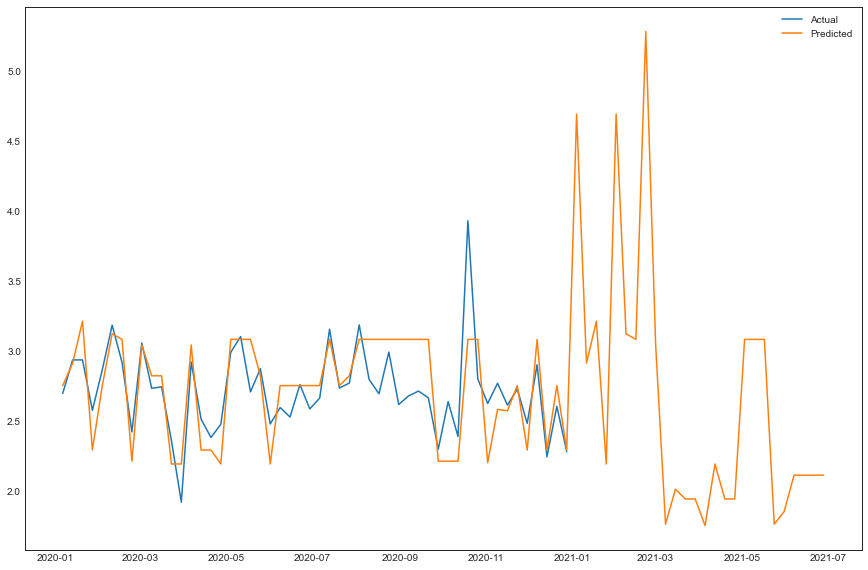

In [75]:
squid = Run_Predict(train, '오징어')

### Ensemble 모델 2020년 RMSE (오징어) by 자율평가데이터

In [76]:
vote_df_squid = vote_df.copy()
vote_df_squid = vote_df_squid['PREDICT_PRICE']

check2 = check.loc[check['P_NAME'] == '오징어']
check2 = check2.groupby('REG_DATE').mean()
check3 = check2['P_PRICE']

squid_rmse = mean_squared_error(vote_df_squid, check3)
squid_rmse = squid_rmse **0.5
squid_rmse

0.24567840219745726

### Ensemble 모델 실행 (연어)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done 126 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 346 tasks      | elapsed:   13.9s
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:   17.0s finished


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Validation Check (train vs validation) 연어 lgbm의 2020년 RMSE : 2.8408646875486485


========== Predicted ==========
Validation Check (train vs validation) 연어 rf의 2020년 RMSE : 2.8430310415287288


========== Predicted ==========
Validation Check (train vs validation) 연어 svr의 2020년 RMSE : 5.861413974602532


========== Predicted ==========


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is av



========== A R I M A ==========


========== Predicted ==========
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 366 tasks      | elapsed:   14.2s
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:   17.1s finished


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Validation Check (train vs validation) 연어 lgbm의 2021년 RMSE : 2.8408646875486485


========== Predicted ==========
Validation Check (train vs validation) 연어 rf의 2021년 RMSE : 2.8430310415287288


========== Predicted ==========
Validation Check (train vs validation) 연어 svr의 2021년 RMSE : 5.861413974602532


========== Predicted ==========


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is av



========== A R I M A ==========


========== Predicted ==========


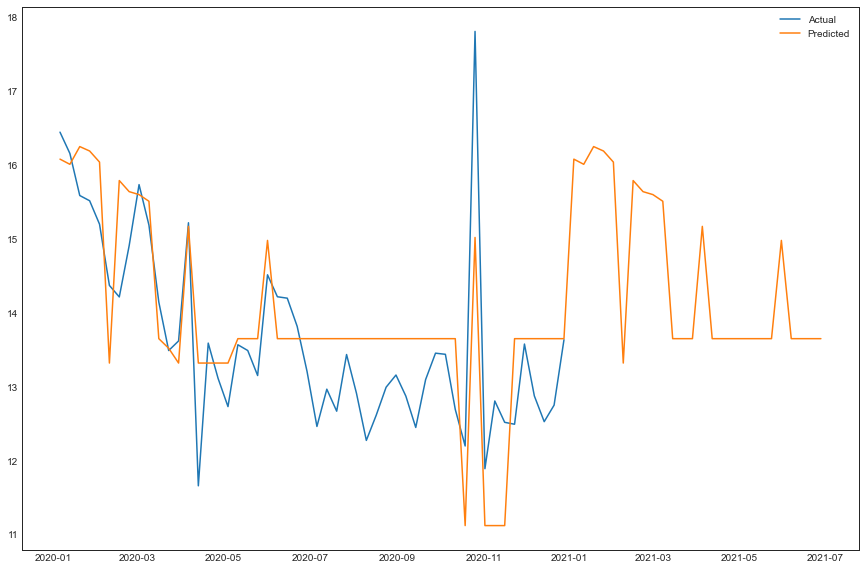

In [78]:
salmon = Run_Predict(train, '연어')

### Ensemble 모델 2020년 RMSE (연어) by 자율평가데이터

In [79]:
vote_df_salmon = vote_df.copy()
vote_df_salmon = vote_df_salmon['PREDICT_PRICE']

check2 = check.loc[check['P_NAME'] == '연어']
check2 = check2.groupby('REG_DATE').mean()
check3 = check2['P_PRICE']

salmon_rmse = mean_squared_error(vote_df_salmon, check3)
salmon_rmse = salmon_rmse **0.5
salmon_rmse

0.8735772860521902

### Ensemble 모델 실행 (흰다리새우)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:   20.1s
[Parallel(n_jobs=10)]: Done 461 out of 480 | elapsed:   31.0s remaining:    1.2s
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:   31.3s finished


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Validation Check (train vs validation) 흰다리새우 lgbm의 2020년 RMSE : 1.393365027611202


========== Predicted ==========
Validation Check (train vs validation) 흰다리새우 rf의 2020년 RMSE : 1.3958849330166787


========== Predicted ==========
Validation Check (train vs validation) 흰다리새우 svr의 2020년 RMSE : 2.8441614228966325


========== Predicted ==========


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is av



========== A R I M A ==========


========== Predicted ==========
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.6s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:   20.3s
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:   31.0s finished


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Validation Check (train vs validation) 흰다리새우 lgbm의 2021년 RMSE : 1.393365027611202


========== Predicted ==========
Validation Check (train vs validation) 흰다리새우 rf의 2021년 RMSE : 1.3958849330166787


========== Predicted ==========
Validation Check (train vs validation) 흰다리새우 svr의 2021년 RMSE : 2.8441614228966325


========== Predicted ==========


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been pr

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is av



========== A R I M A ==========


========== Predicted ==========


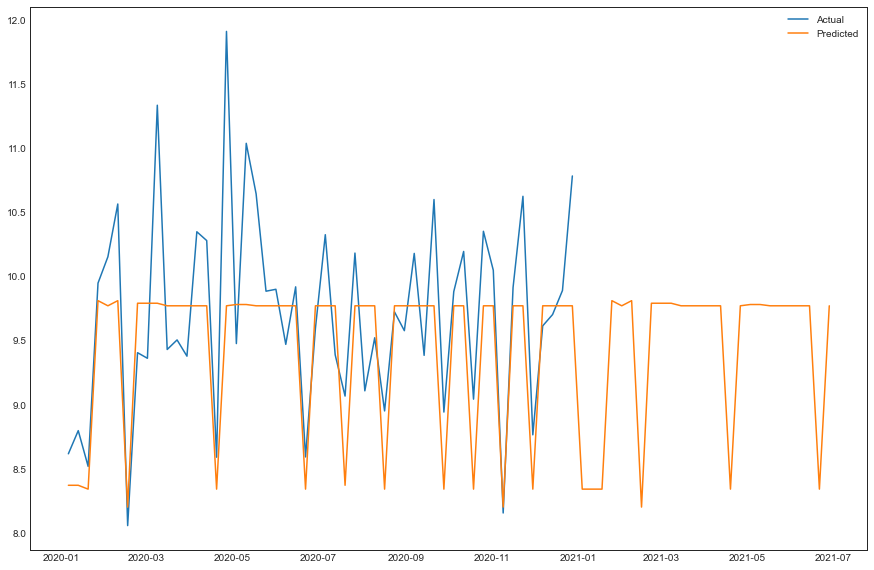

In [80]:
shrimp = Run_Predict(train, '흰다리새우')

### Ensemble 모델 2020년 RMSE (흰다리새우) by 자율평가데이터

In [81]:
vote_df_shrimp = vote_df.copy()
vote_df_shrimp = vote_df_shrimp['PREDICT_PRICE'].astype(float)

check2 = check.loc[check['P_NAME'] == '흰다리새우']
check2 = check2.groupby('REG_DATE').mean()
check3 = check2['P_PRICE']

shrimp_rmse = mean_squared_error(vote_df_shrimp, check3)
shrimp_rmse = shrimp_rmse **0.5
shrimp_rmse

0.5961251734550552

In [82]:
squid

,PREDICT_MODEL,FINAL_VALUE
REG_DATE,,
2021-01-04,SVR,4.69
2021-01-11,ARIMA,2.91
2021-01-18,ARIMA,3.21
2021-01-25,RF,2.19
2021-02-01,SVR,4.69
2021-02-08,ARIMA,3.12
2021-02-15,ARIMA,3.08
2021-02-22,SVR,5.28
2021-03-01,ARIMA,3.04


In [83]:
salmon

,PREDICT_MODEL,FINAL_VALUE
REG_DATE,,
2021-01-04,ARIMA,16.08
2021-01-11,ARIMA,16.01
2021-01-18,ARIMA,16.25
2021-01-25,ARIMA,16.19
2021-02-01,ARIMA,16.04
2021-02-08,SVR,13.32
2021-02-15,ARIMA,15.79
2021-02-22,ARIMA,15.64
2021-03-01,ARIMA,15.60


In [84]:
shrimp

,PREDICT_MODEL,FINAL_VALUE
REG_DATE,,
2021-01-04,LGBM,8.34
2021-01-11,LGBM,8.34
2021-01-18,LGBM,8.34
2021-01-25,ARIMA,9.81
2021-02-01,ARIMA,9.77
2021-02-08,ARIMA,9.81
2021-02-15,SVR,8.20
2021-02-22,ARIMA,9.79
2021-03-01,ARIMA,9.79


In [87]:
squid.to_csv('BigContact_result_squid.csv', encoding='utf-8-sig')
salmon.to_csv('BigContact_result_salmon.csv', encoding='utf-8-sig')
shrimp.to_csv('BigContact_result_shrimp.csv', encoding='utf-8-sig')